# Turbidity in wetlands <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[wofs_albers](https://explorer.sandbox.dea.ga.gov.au/wofs_albers),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3),
[ga_ls9c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls9c_ard_3)

## Background

In this notebook, we calculate turbidity in wetland areas through the Normalised Difference Turbidity Index `NDTI2`*. Turbidity refers to the optical clarity of the water. While it is not strictly correlated with suspended matter, chlorophyll content, or other metrics, it is often used in conjunction to provide a more holistic analysis of water quality. 

NDTI2 is a band index defined by [Lacaux et al, 2007](https://www.sciencedirect.com/science/article/abs/pii/S0034425706002811) as:

$\text{NDTI2} = \frac{\text{Red} - \text{Green}}{\text{Red} + \text{Green}}$



Here, we investigate NDTI2 over wetland areas in a several-year time series, through both a seasonal animation and a time series plot.

*NB. The 'NDTI' acronym is already in use within the DEA Ecosystem as the 'Normalised Difference Tillage Index'.
Instead, we are using the acronym 'NDTI2' and the Normalised Difference Turbidity Index is NDTI2 in the DEA `calculate_indices` function.


## Description
1. Load packages and connect to the datacube
2. Define area of interest and time range
3. Mask areas with water using WOfS
4. Plot and animate
5. Investigate wetlands extent over time

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline


import datacube
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
from IPython.display import Image
import geopandas
from geopandas import GeoDataFrame

from dea_tools.plotting import display_map, rgb, xr_animation
from dea_tools.spatial import xr_vectorize, xr_rasterize
from dea_tools.datahandling import load_ard, mostcommon_crs, wofs_fuser
from dea_tools.bandindices import calculate_indices

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Wetland_turbidity")

### Define area of interest

In [3]:
# Define the area of interest
lat = -15.87
lon = 136.63

lat_buffer = 0.15
lon_buffer = 0.15


# Time period
time_range = ("2018-01-01", "2023-12-31")

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

display_map(x=lon_range, y=lat_range)

## Load satellite data

The first step in the analysis is to load Landsat 8 and 9 data for the specified area of interest.
This uses the pre-defined [load_ard](../Frequently_used_code/Using_load_ard.ipynb) utility function. 
The `load_ard` function is used here to load an analysis ready dataset free of shadow, and missing data.

Note that specifying the parameter `min_gooddata=0.9` reduces data from the middle of the year, when this area experiences maximum cloudy weather.

In [4]:
query = {
    "x": lon_range,
    "y": lat_range,
    "time": time_range,
    "resolution": (-30, 30),
    "align": (15, 15),
}


# Define the coordinate system
output_crs = "EPSG:3577"

ds = load_ard(
    dc=dc,
    products=["ga_ls8c_ard_3", "ga_ls9c_ard_3"],
    measurements=["red", "green", "blue", "nir"],
    group_by="solar_day",
    dask_chunks={"time": 1, "x": 2000, "y": 2000},
    output_crs=output_crs,
    min_gooddata=0.9,
    **query
)

Finding datasets
    ga_ls8c_ard_3
    ga_ls9c_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 95 out of 358 time steps with at least 90.0% good quality pixels
Applying fmask pixel quality/cloud mask
Returning 95 time steps as a dask array


In [5]:
# Display the dataset `ds`
ds

<xarray.Dataset>
Dimensions:      (time: 95, y: 1139, x: 1118)
Coordinates:
  * time         (time) datetime64[ns] 2018-04-21T00:58:31.666695 ... 2023-12...
  * y            (y) float64 -1.679e+06 -1.679e+06 ... -1.713e+06 -1.713e+06
  * x            (x) float64 4.82e+05 4.82e+05 4.821e+05 ... 5.155e+05 5.155e+05
    spatial_ref  int32 3577
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 1139, 1118), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 1139, 1118), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1139, 1118), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1139, 1118), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## Load WOfS

Values of NDTI2 are relative and the index should only be applied to water. Including land in the area of interest will skew the colourmap. All-time WOfS is used here to threshold for areas pixels which are likely to be water.

In [6]:
water = dc.load(
    product="wofs_summary",
    like=ds.geobox,
    dask_chunks={"time": 1, "x": 2000, "y": 2000},
)
# extract from mask the areas classified as water
water_extent = (water.frequency > 0.15).squeeze()

print(water_extent)

<xarray.DataArray 'frequency' (y: 1139, x: 1118)>
dask.array<getitem, shape=(1139, 1118), dtype=bool, chunksize=(1139, 1118), chunktype=numpy.ndarray>
Coordinates:
    time         datetime64[ns] 1970-01-01
  * y            (y) float64 -1.679e+06 -1.679e+06 ... -1.713e+06 -1.713e+06
  * x            (x) float64 4.82e+05 4.82e+05 4.821e+05 ... 5.155e+05 5.155e+05
    spatial_ref  int32 3577


### Inspect water extent

/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


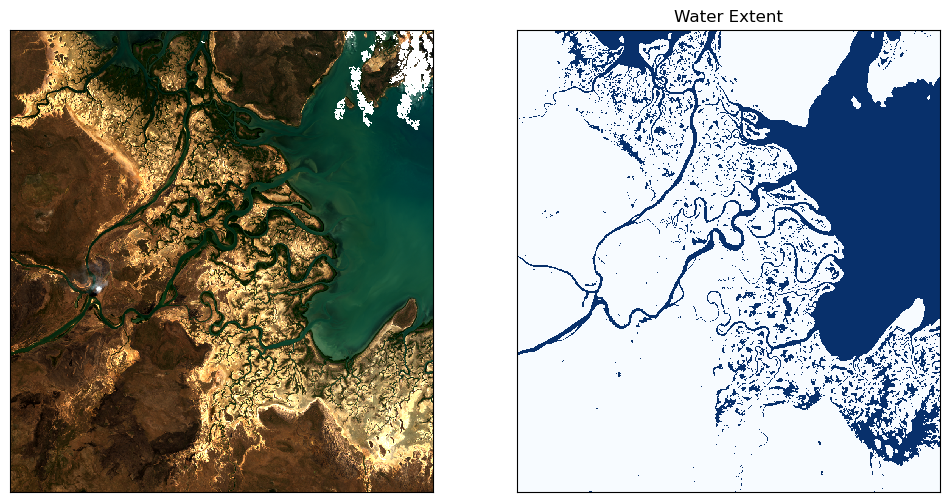

In [7]:
# Plot the geomedian composite and water extent
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# plot the true colour image
rgb(ds.isel(time=5), bands=["red", "green", "blue"], ax=ax[0])

# plot the water extent from WOfS
water_extent.plot.imshow(ax=ax[1], cmap="Blues", add_colorbar=False)

# Titles
ax[0].set_title(""), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title("Water Extent"), ax[1].xaxis.set_visible(False), ax[
    1
].yaxis.set_visible(False);

## Plot NDTI2

Here we calculate NDTI2 and add it to the loaded data set. It also generates an animation that is exported to the sandbox and can be saved by right-clicking the `.gif` and selecting "Download".

In [8]:
ds = calculate_indices(ds.where(water_extent), index="NDTI2", collection="ga_ls_3")

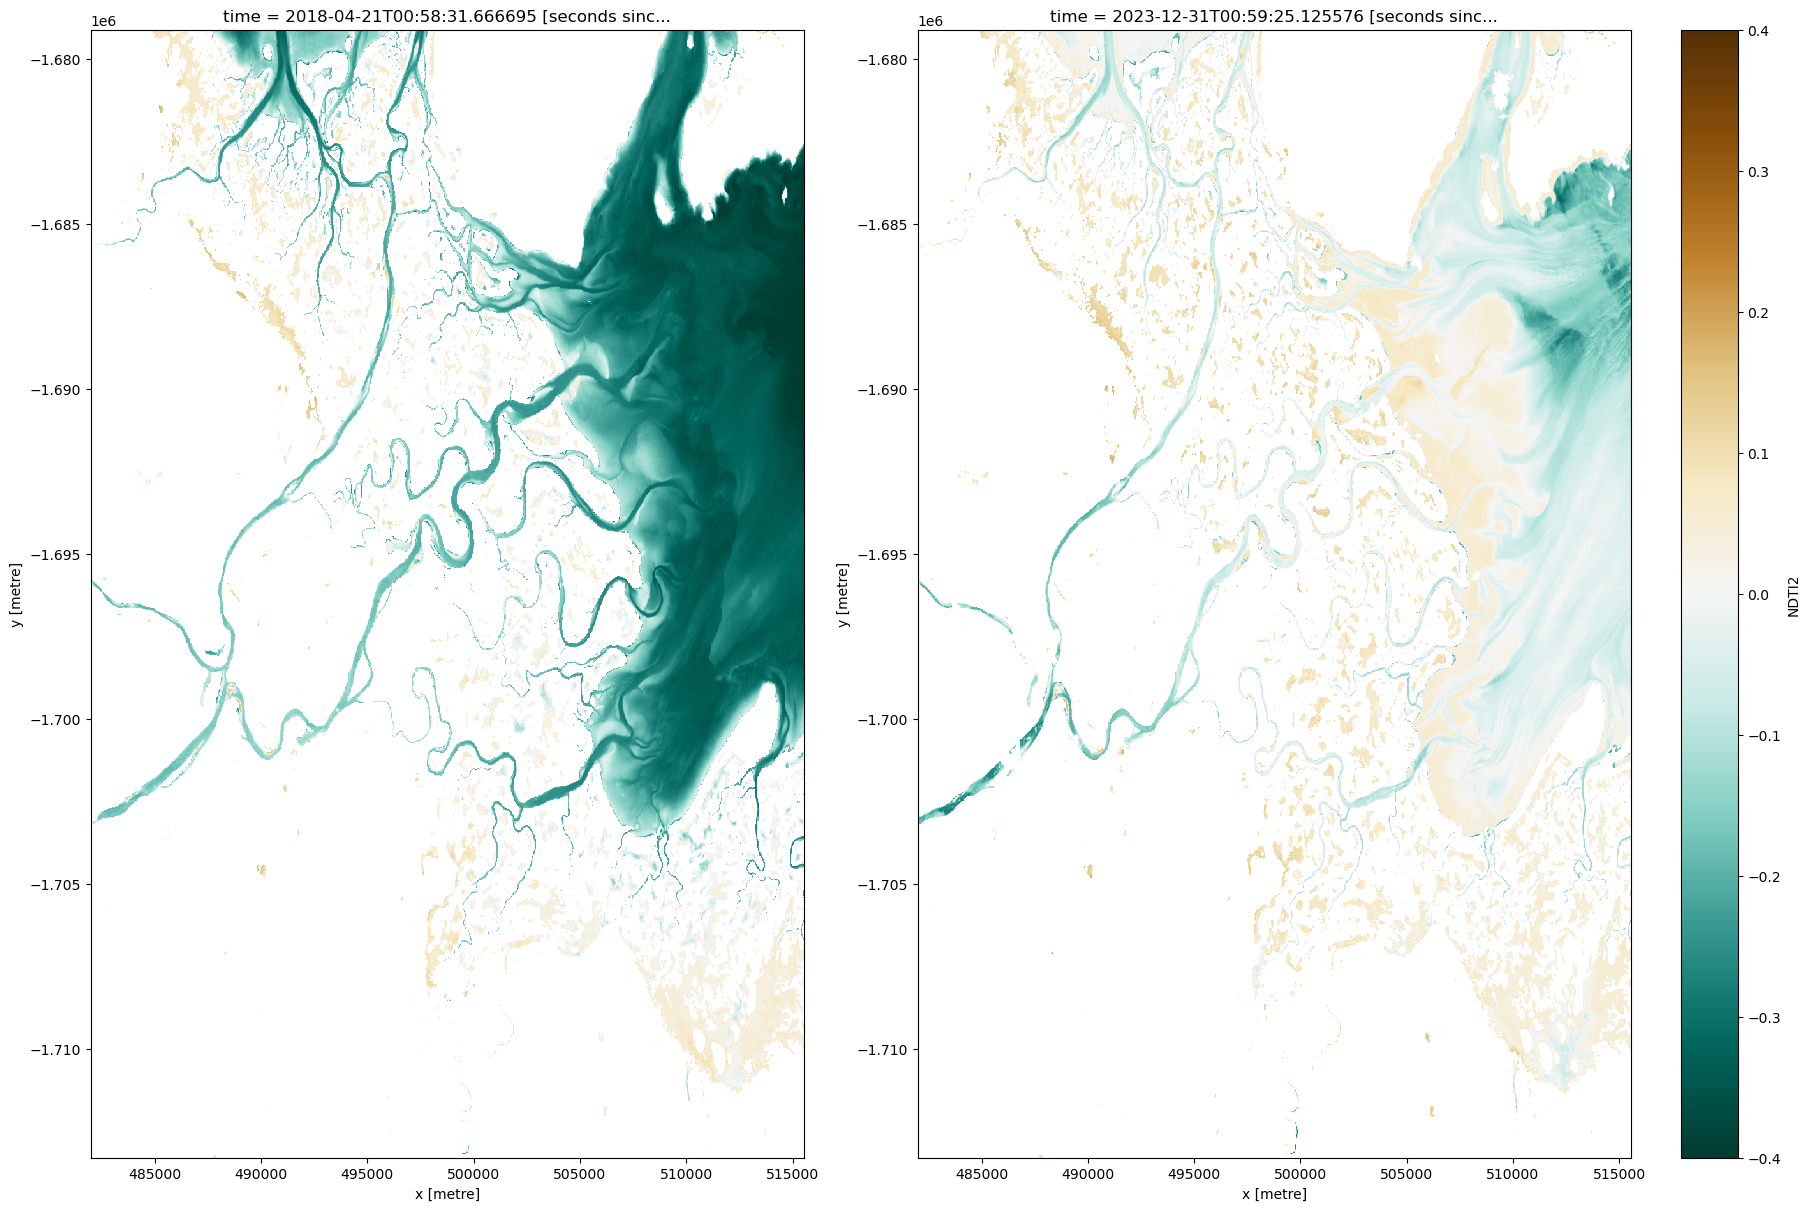

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(18, 12), constrained_layout=True)
cmap = "BrBG_r"
vmin = -0.4
vmax = 0.4

ds.NDTI2.isel(time=0).plot(
    ax=ax[0], cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax
)
ds.NDTI2.isel(time=-1).plot(
    ax=ax[1], cmap=cmap, add_colorbar=True, vmin=vmin, vmax=vmax
)

Exporting animation to NDTI2_2018-01-01_2023-12-31.gif


  0%|          | 0/95 (0.0 seconds remaining at ? frames/s)

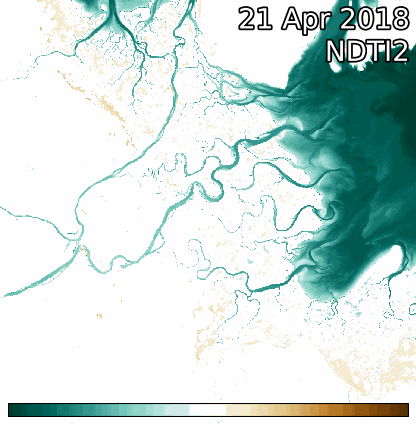

In [10]:
# Produce time series animation of NDTI2
xr_animation(
    ds=ds,
    output_path="NDTI2_" + time_range[0] + "_" + time_range[1] + ".gif",
    bands=["NDTI2"],
    show_text="NDTI2",
    interval=250,
    imshow_kwargs={"cmap": "BrBG_r", "vmin": vmin, "vmax": vmax},
    width_pixels=300,
)

# Plot animated gif
plt.close()
Image(filename="NDTI2_" + time_range[0] + "_" + time_range[1] + ".gif")

### Investigate size of waterbodies

The animated timeseries and plots above show a distinct difference in NDTI2 between large watercourses which generally appear blue-white, and smaller waterbodies which appear more orange to brown in the colour scheme. 

We might hypothesise that smaller waterbodies generally have higher NDTI2 values than larger ones, meaning they are more turbid. The histogram below suggests this might be the case as there are two peaks evident. We can test this further by splitting the the waterbodies by size below.

Text(0, 0.5, 'Count of pixels')

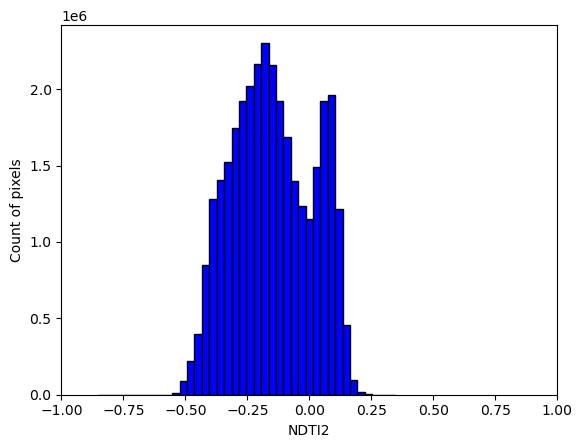

In [11]:
plt.hist(ds.NDTI2.to_numpy().flatten(), color="blue", edgecolor="black", bins=40)
plt.xlim((-1, 1))

# Add labels
plt.xlabel("NDTI2")
plt.ylabel("Count of pixels")

### Vectorize waterbodies

We will split the waterbodies into two size classes, small and large, at a threshold of 50,000 square metres. You can adjust the threshold and test it in the plots below.

In [12]:
polygons = xr_vectorize(water_extent, mask=water_extent == True)
polygons["area"] = polygons.area
polygons["size"] = np.where(polygons["area"] < 50000, 1, 2)  # se

The interactive plot below shows larger waterbodies in yellow and smaller ones in purple.

In [13]:
# Use the GeoPandas explore function to visualize the polygons in polygons symbolized according to large and small size classes.
polygons.explore("size")

Here, we rasterize polygons and mask NDTI2 to small and large waterbodies, then calculate mean and standard deviation timeseries. This allows us to plot the timeseries in the cell below. The plot confirms that smaller waterbodies have higher NDTI2 values than larger ones, and the two size classes follow the same pattern over time.

In [14]:
water_size = xr_rasterize(gdf=polygons, da=water, attribute_col='size')

ds_large = ds.where(water_size==2)
ds_small = ds.where(water_size==1)

NDTI2_ts_large = ds_large.NDTI2.mean(['x','y'])
NDTI2_ts_small = ds_small.NDTI2.mean(['x','y'])
NDTI2_ts_large_std = ds_large.NDTI2.std(['x','y'])
NDTI2_ts_small_std = ds_small.NDTI2.std(['x','y'])

/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


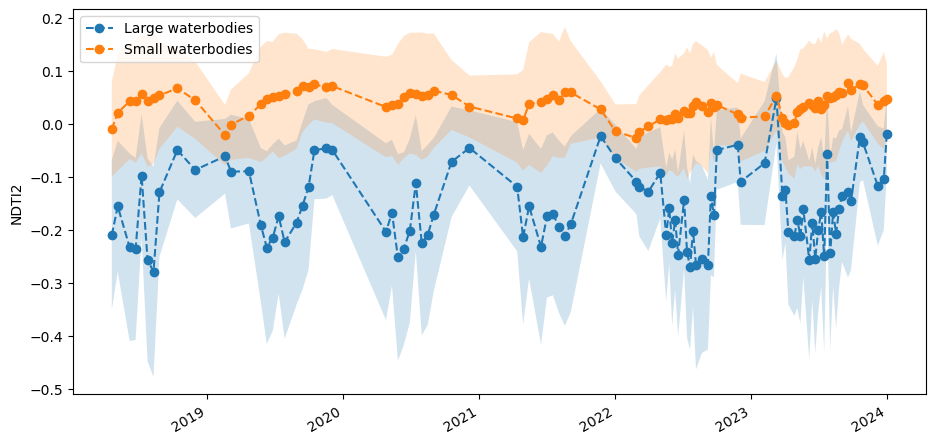

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
NDTI2_ts_large.plot(ax=ax, label='Large waterbodies', linestyle='dashed', marker='o')
NDTI2_ts_small.plot(ax=ax, label='Small waterbodies', linestyle='dashed', marker='o')
ax.fill_between(
    NDTI2_ts_large.time,
    NDTI2_ts_large-NDTI2_ts_large_std,
    NDTI2_ts_large+NDTI2_ts_large_std,
    alpha=0.2,
)
ax.fill_between(
    NDTI2_ts_small.time,
    NDTI2_ts_small-NDTI2_ts_small_std,
    NDTI2_ts_small+NDTI2_ts_small_std,
    alpha=0.2,
)
plt.legend(loc="upper left")
plt.title("")
plt.xlabel("");

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Compatible datacube version:** 

In [16]:
print(datacube.__version__)

1.8.17


**Last Tested:**

In [17]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2024-02-02'

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)